In [10]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

data_dir = "/content"

In [11]:
# Visualise how our data looks
pd.read_csv('Occupancy.csv').head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [12]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

for file in tqdm_notebook(os.listdir(data_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue
    
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv('{}/{}'.format(data_dir, file), parse_dates=[0])
    #print(df)
    # Processing the time data into suitable input formats
    df['hour'] = df.apply(lambda x: x['date'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['date'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['date'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['date'].dayofyear,axis=1)
    df = df.sort_values('date').drop('date',axis=1)
    
    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,5].values.reshape(-1,1))
    label_scalers[file] = label_sc
    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)
    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,5]
    
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)
    
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])


<ipython-input-12-f12176feca8e>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(os.listdir(data_dir)):


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
batch_size = 1024
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)



In [14]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [15]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [16]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print(out)
            #print(label.to(device).float())
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.time()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.time()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.time()-start_time)))
    MSE = 0
    for i in range(len(outputs)):
        MSE += np.square(np.subtract(targets[i],outputs[i])).mean()
        print(outputs[i][0],targets[i][0])
    print("MSE: {}%".format(MSE*100))
    return outputs, targets, MSE

In [17]:

lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")
Lstm_model = train(train_loader, lr, model_type="LSTM")


Starting Training of GRU model
Epoch 1/5 Done, Total Loss: 0.0584857892792891
Total Time Elapsed: 2.9213976860046387 seconds
Epoch 2/5 Done, Total Loss: 0.010914032840553452
Total Time Elapsed: 2.4191689491271973 seconds
Epoch 3/5 Done, Total Loss: 0.00834509453681462
Total Time Elapsed: 2.4447901248931885 seconds
Epoch 4/5 Done, Total Loss: 0.0076016804258174754
Total Time Elapsed: 2.470818519592285 seconds
Epoch 5/5 Done, Total Loss: 0.007175103186027092
Total Time Elapsed: 2.5701966285705566 seconds
Total Training Time: 12.826371908187866 seconds
Starting Training of LSTM model
Epoch 1/5 Done, Total Loss: 0.10767103633021607
Total Time Elapsed: 3.0089869499206543 seconds
Epoch 2/5 Done, Total Loss: 0.020523384706500697
Total Time Elapsed: 3.038034200668335 seconds
Epoch 3/5 Done, Total Loss: 0.01373920014456791
Total Time Elapsed: 3.0434834957122803 seconds
Epoch 4/5 Done, Total Loss: 0.012209790073992574
Total Time Elapsed: 3.16434645652771 seconds
Epoch 5/5 Done, Total Loss: 0.011

In [18]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)
lstm_outputs, targets, lstm_sMAPE = evaluate(Lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 0.0716397762298584
0.0073105693 0.0
MSE: 0.4439763289935797%
Evaluation Time: 0.1004786491394043
0.010311954 0.0
MSE: 1.0840448472205064%


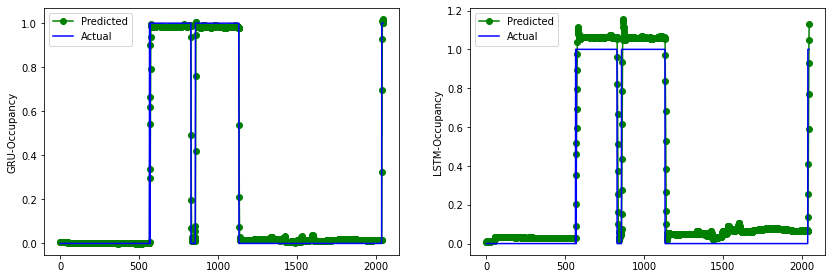

In [19]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-2100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-2100:], color="b", label="Actual")
plt.ylabel('GRU-Occupancy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(lstm_outputs[0][-2100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-2100:], color="b", label="Actual")
plt.ylabel('LSTM-Occupancy')
plt.legend()
plt.show()